# Stellar Scatter Plots
Stellar effective temperature, surface gravity, metallicity, radius, mass, should comprise a consistent set. Associated error estimates are 1-σ uncertainties.

In [7]:
# Python imports and settings
import numpy  as np
import pandas as pd
import seaborn as sns
import scipy.stats
import re
from pydash import py_ as _
from sklearn.preprocessing import OneHotEncoder

from src.dataset_koi import koi, koi_columns, koi_column_types
from src.utilities import onehot_encode_comments

# https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  # 8 is required for .describe()

sns.set(rc={'figure.figsize':(20,20)})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# cmap = sns.color_palette("YlOrRd_r", 10)
# sns.set_palette(cmap)
# sns.palplot(cmap)

In [3]:
dataset = (
    pd.DataFrame.join(
        koi['archive'][['koi_disposition']], 
        koi['stellar']
    )
    .drop(columns='koi_sparprov')
    .sort_values(by='koi_disposition')
)
dataset

,koi_disposition,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
kepoi_name,,,,,,
K05834.01,CANDIDATE,6095.0,4.429,0.14,1.082,1.150
K02206.01,CANDIDATE,5751.0,4.458,-0.02,0.958,0.962
K04653.01,CANDIDATE,6392.0,4.399,0.07,1.162,1.232
K03168.01,CANDIDATE,5843.0,4.086,-0.20,1.471,0.963
...,...,...,...,...,...,...
K03842.01,FALSE POSITIVE,4509.0,4.612,-0.16,0.663,0.656
K07811.01,FALSE POSITIVE,5724.0,4.530,-0.38,0.827,0.845
K03849.01,FALSE POSITIVE,3569.0,4.820,0.00,0.427,0.439
K07989.01,FALSE POSITIVE,6469.0,4.385,0.07,1.193,1.260


## Correlation with Laws of Physics

- koi_steff  - Stellar Effective Temperature (Kelvin) - The photospheric temperature of the star.
- koi_slogg  - Stellar Surface Gravity (log10(cm s-2)) - The base-10 logarithm of the acceleration due to gravity at the surface of the star
- koi_smet   - Stellar Metallicity - The base-10 logarithm of the Fe to H ratio at the surface of the star, normalized by the solar Fe to H ratio
- koi_srad   - Stellar Radius (solar radii) - The photospheric radius of the star
- koi_smass  - Stellar Mass (solar mass) - The mass of the star

In [100]:
print()
print('ALL')
display(
    dataset.corr()
        .apply(lambda x: round(x,2))
        .style.background_gradient()
)
print()
print('CONFIRMED')
display(
    dataset[ dataset['koi_disposition'] == 'CONFIRMED' ].corr()
        .apply(lambda x: round(x,2))
        .style.background_gradient()
)
print()
print(disposition + ' / ALL')
display(
    dataset[ dataset['koi_disposition'] == 'CONFIRMED' ].corr()
        .divide( dataset.corr() )
        .apply(lambda x: round(x,2))
        .style.background_gradient()
)


ALL


,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
koi_steff,1,-0.14,-0.03,-0.12,0.59
koi_slogg,-0.14,1,-0.05,-0.64,-0.69
koi_smet,-0.03,-0.05,1,0.01,0.24
koi_srad,-0.12,-0.64,0.01,1,0.32
koi_smass,0.59,-0.69,0.24,0.32,1



CONFIRMED


,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
koi_steff,1,-0.58,0.08,0.36,0.81
koi_slogg,-0.58,1,-0.29,-0.83,-0.8
koi_smet,0.08,-0.29,1,0.24,0.37
koi_srad,0.36,-0.83,0.24,1,0.76
koi_smass,0.81,-0.8,0.37,0.76,1



CONFIRMED / ALL


,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
koi_steff,1,4.16,-2.95,-3.08,1.38
koi_slogg,4.16,1,5.51,1.29,1.15
koi_smet,-2.95,5.51,1,18.05,1.55
koi_srad,-3.08,1.29,18.05,1,2.41
koi_smass,1.38,1.15,1.55,2.41,1


Observations:
- As expected by the laws of physics (more fuel = hotter and bigger)
  - Stellar Mass (koi_smass) is strongly correlated with Surface Temperature (koi_steff)
  - Stellar Mass (koi_smass) is also correlated with Metallicity (koi_smet) and Radius (koi_srad)
  - Radius (koi_srad) - and by extension Stellar Mass - is anti-correlated with log10 Surface Gravity (koi_slogg) 
  
  
- Dividing correlations going from ALL -> CONFIRMED:
  - Mass/Radius = increases in correlation
  - Metallicity/Radius = uncorrelated for ALL | correlated for CONFIRMED
  - Metallicity/Gravity + Temperature/Gravity = increase in anti-correlatedness 
  - Temperature/Radius + Temperature/Metallicity = anti-correlated for ALL | correlated for CONFIRMED

## Disposition Scatter Plots

- The database of CONFIRMED KOI's may not reflect the true distribution of exoplanets, but also suffers from the selection effects of the transit method of detection

Stellar Mass vs Radius - increases in correlation


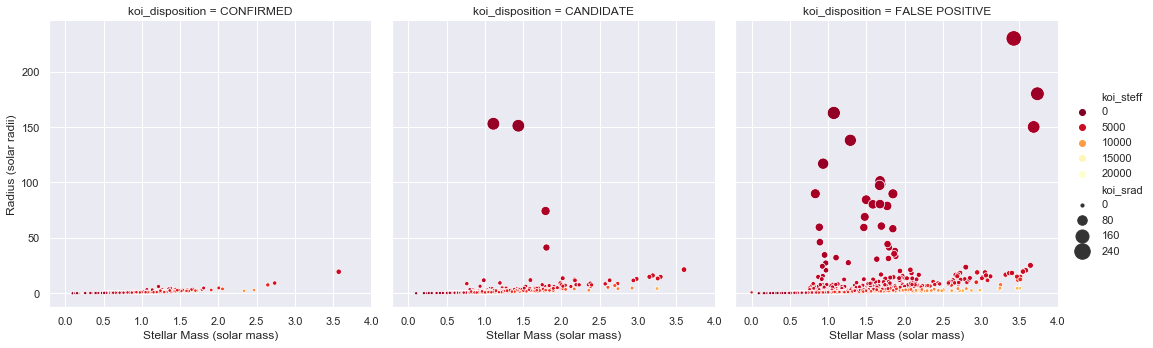

In [113]:
print('Stellar Mass vs Radius - increases in correlation')
facetgrid = sns.relplot(
    data=dataset,    
    kind="scatter",
    col="koi_disposition", 
    col_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],

    x="koi_smass",     
    y="koi_srad",
    size="koi_srad", sizes=(10,240),

    hue="koi_steff", palette="YlOrRd_r",

).set_axis_labels("Stellar Mass (solar mass)", "Radius (solar radii)")

Observations:
- Keplar has had most luck finding explanets around:
    - Lower mass stars (< 2 solar masses)
    - Lower temperature stars
    - Red Dwarfs + Main Sequence Stars but not Red Giants
    
    
- Possible explanations:
    - Red Giants may have gobbled up many of their planets (less exoplanets to be found)
    - Hot, large, bright stars reduce the relative dimming of a transit (exoplanets are harder to see)

Metallicity vs Radius - correlated for CONFIRMED - uncorrelated for ALL


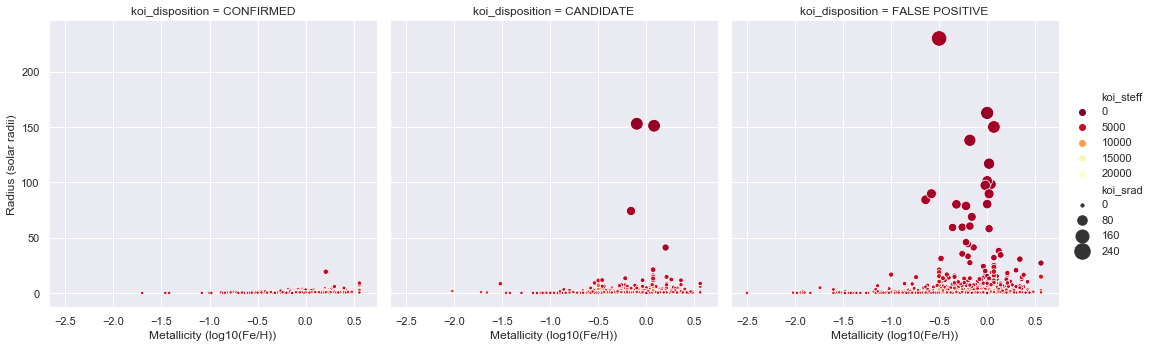

In [114]:
print('Metallicity vs Radius - correlated for CONFIRMED - uncorrelated for ALL')
sns.relplot(
    data=dataset,    
    kind="scatter",
    col="koi_disposition", 
    col_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],
    
    x="koi_smet",     
    y="koi_srad",
    size="koi_srad", sizes=(10,240),
    
    hue="koi_steff", palette="YlOrRd_r",
).set_axis_labels("Metallicity (log10(Fe/H))", "Radius (solar radii)")

Observations:

- Exoplanets are found more often around high-metalicity stars (more material for rocky planets)
- Large Red Giants have a minimum metalicity threshold (nuclear astrophysics)    

Temperature vs Radius - anti-correlated for ALL | correlated for CONFIRMED


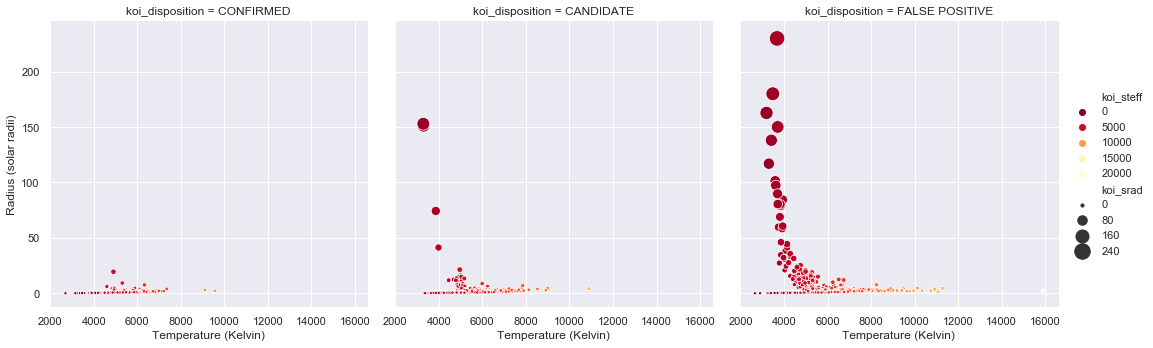

In [123]:
print('Temperature vs Radius - anti-correlated for ALL | correlated for CONFIRMED')
sns.relplot(
    data=dataset,    
    kind="scatter",
    col="koi_disposition", 
    col_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],
    
    x="koi_steff",     
    y="koi_srad",
    size="koi_srad", sizes=(10,240),
    
    hue="koi_steff", palette="YlOrRd_r",
).set_axis_labels("Temperature (Kelvin)", "Radius (solar radii)")

Observations:

- Exoplanets are found more often around small low-temperature stars

## Starmap

Star Observations:
- The bottom right of the grid is closest to the Galactic Rim, thus has a greater overall star density
- Visually there appears to be a greater ratio of CONFIRMED to FALSE POSITIVE away from the Galactic 

lower half of the grid search 


- There 

Map Observations:
- Each square represents the stationary field of view of the Kepler Space Telescope
- Kepler was repointed 21 times in a grid search pattern during its 9 year mission
- The slight curvature of the grid represents the projection of a sphere onto a flat surface

<img src="https://www.nasa.gov/sites/default/files/styles/full_width_feature/public/thumbnails/image/milkyway-kepler-croberts-1-full_0.png"/>

<center>Source: <a href="https://www.nasa.gov/ames/kepler/kepler-field-of-view">https://www.nasa.gov/ames/kepler/kepler-field-of-view</a></center>

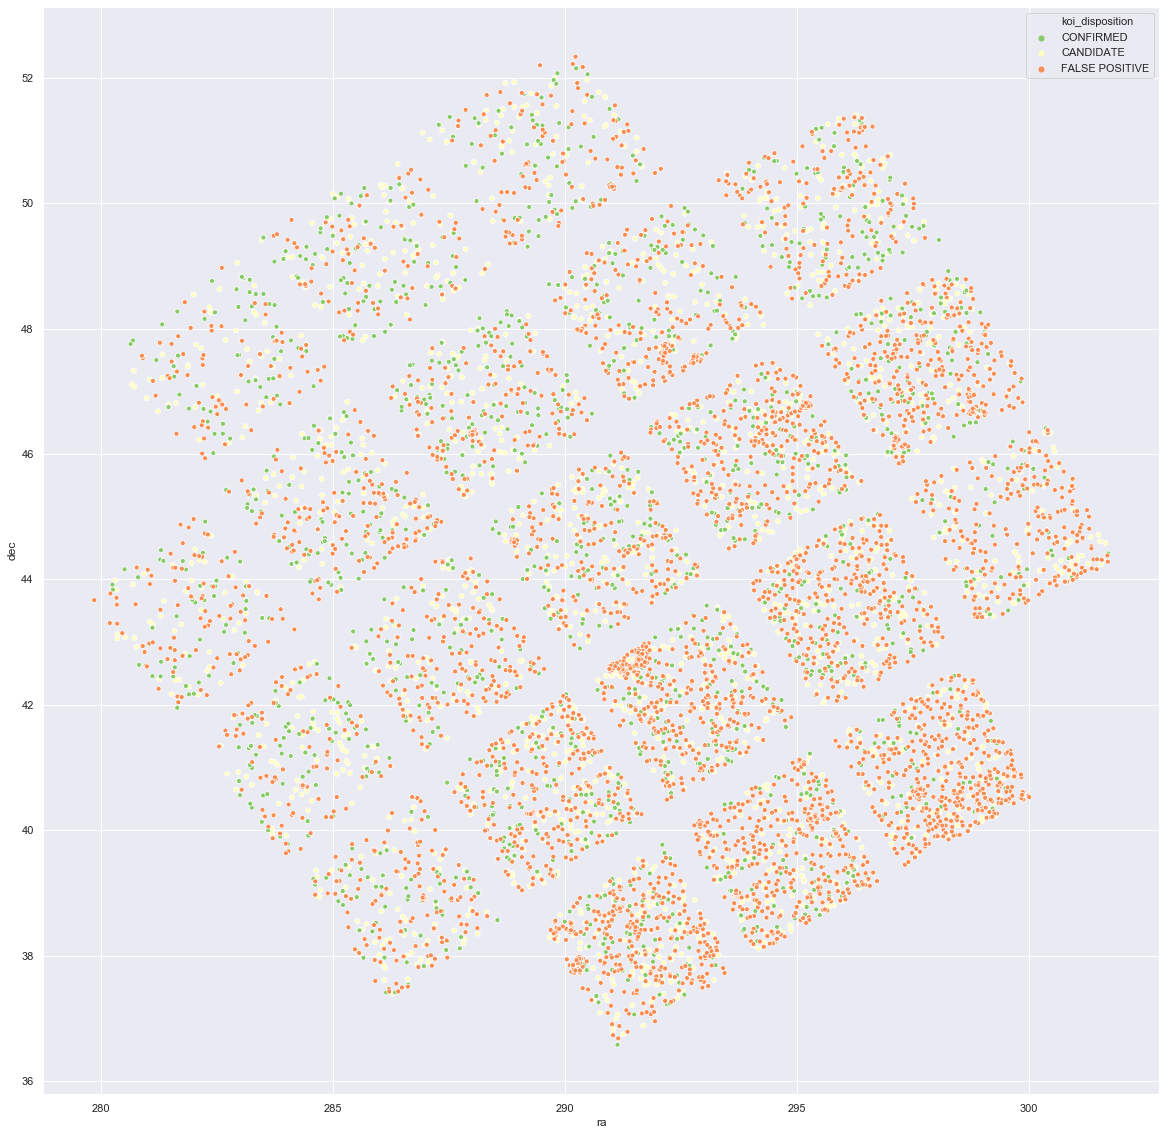

In [175]:
display(
    sns.scatterplot(
        data=dataset.join( koi['KIC'] ),
        x="ra",     
        y="dec",
        sizes=(25,25),
        size="koi_disposition", 
        size_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],

        hue="koi_disposition", palette="RdYlGn_r",
        hue_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],
    )
)

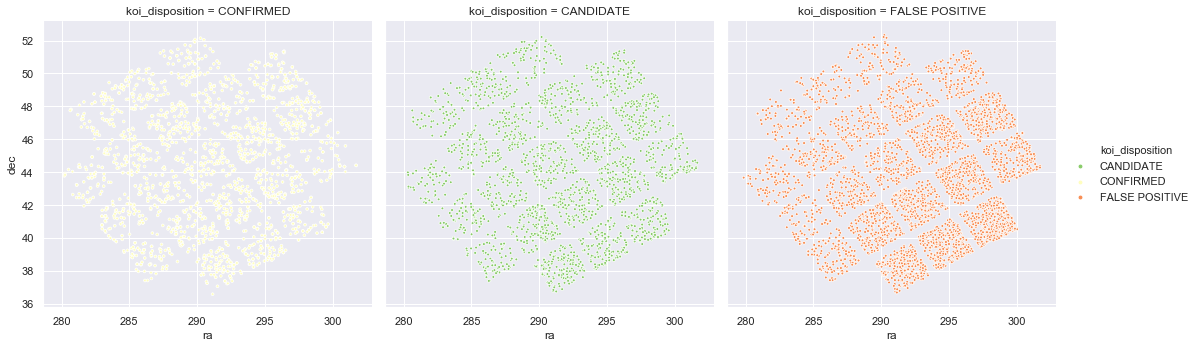

In [201]:
sns.relplot(
    data=dataset.join( koi['KIC'] ),    
    kind="scatter",
    col="koi_disposition", 
    col_order=['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE'],
    
    x="ra",     
    y="dec",    
    
    size='koi_disposition',
    sizes=(8,8),    
    hue="koi_disposition", palette="RdYlGn_r",
)